<a href="https://colab.research.google.com/github/rtedwards/nn-zero-to-hero/blob/main/notebooks/4_makemore_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Back Propagation
- [Yes you should understand BackProp](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
- Need to understand back prop to be able to debug

In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

In [2]:
words = open("names.txt", "r").read().splitlines()

In [18]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## I. Build Dataset

In [19]:
def build_dataset(words, block_size = 3):
    """
    - block_size - context length: how many characters fo we take to predict the next one?
    """
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

## II. Data set Splits

- Training (80%) - used to optimize the model parameters
- Validation (10%) - used to optimize the model hyperparameters(number of neurons, size of hidden layer, size of embedding, strength of regularization)
- Test (10%) - used to evaluate model as it generalizes to unseen data

In [20]:
# train / validation / test splits
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
block_size = 3 # number of previous characters

X_train, Y_train = build_dataset(words[:n1], block_size)
X_val, Y_val = build_dataset(words[n1:n2], block_size)
X_test, Y_test = build_dataset(words[n2:], block_size)

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [21]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [41]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
# embedding layer for characters
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

# BatchNorm parameters
bn_gain = torch.randn((1, n_hidden))*0.1 + 1.0
bn_bias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True


4137


In [42]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience

# construct a minibatch
ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

In [43]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm layer
bn_mean_i = 1/n*hprebn.sum(0, keepdim=True)
bn_diff = hprebn - bn_mean_i
bn_diff2 = bn_diff**2
bn_var = 1/(n-1)*(bn_diff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bn_var_inv = (bn_var + 1e-5)**-0.5
bn_raw = bn_diff * bn_var_inv
hpreact = bn_gain * bn_raw + bn_bias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bn_raw,
         bn_var_inv, bn_var, bn_diff2, bn_diff, hprebn, bn_mean_i,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.5198, grad_fn=<NegBackward0>)

In [44]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

d_logprobs = torch.zeros_like(logprobs) #1 / probs[range(n)].log() # 1 / (x ln a)
d_logprobs[range(n), Yb] = -1.0 / n # d/dxi of -(x1 + x2 + ... + xn) / n
d_probs = 1 / probs * d_logprobs    # (local_derivative * chained_derivatives)
d_counts_sum_inv = (counts * d_probs).sum(1, keepdim=True) # (local_derivative * chained_derivatives) then sum across columns
d_counts = counts_sum_inv * d_probs
d_counts_sum = -(counts_sum)**-2 * d_counts_sum_inv
d_counts += torch.ones_like(counts) * d_counts_sum # (add the 2 branches that rely on counts)
d_norm_logits = norm_logits.exp() * d_counts
d_logits = d_norm_logits.clone()
d_logit_maxes = (-d_norm_logits).sum(1, keepdim=True)
d_logits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * d_logit_maxes
d_h = d_logits @ W2.T
d_W2 = h.T @ d_logits
d_b2 = d_logits.sum(0)
d_hpreact = (1.0 - h**2) * d_h # (local_derivative * chained_derivatives)
d_bn_gain = (bn_raw * d_hpreact).sum(0, keepdim=True) # (local_derivative * chained_derivatives)
d_bn_bias = d_hpreact.sum(0, keepdim=True) # (local_derivative * chained_derivatives)
d_bn_raw = bn_gain * d_hpreact # (local_derivative * global_chained_derivative)
d_bn_diff = bn_var_inv * d_bn_raw # (local_derivative * global_chained_derivative)
d_bn_var_inv = (bn_diff * d_bn_raw).sum(0, keepdim=True)
d_bn_var = (-0.5*(bn_var + 1e-5)**-1.5) * d_bn_var_inv
d_bn_diff2 = (1.0/(n-1))*torch.ones_like(bn_diff2) * d_bn_var # (local_derivative * global_chained_derivative)
d_bn_diff += (2.0*bn_diff) * d_bn_diff2
d_bn_mean_i = (-d_bn_diff).sum(0)
d_hprebn = d_bn_diff.clone()
d_hprebn += (1.0/n) * (torch.ones_like(hprebn) * d_bn_mean_i)
d_embcat = d_hprebn @ W1.T
d_W1 = embcat.T @ d_hprebn
d_b1 = d_hprebn.sum(0)
d_emb = d_embcat.view(emb.shape) # rerepresent to original shape (undo the view)
d_C = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        d_C[ix] += d_emb[k,j] # need to add derivatives if reused

cmp('logprobs', d_logprobs, logprobs)
cmp('probs', d_probs, probs)
cmp('counts_sum_inv', d_counts_sum_inv, counts_sum_inv)
cmp('counts_sum', d_counts_sum, counts_sum)
cmp('counts', d_counts, counts)
cmp('norm_logits', d_norm_logits, norm_logits)
cmp('logit_maxes', d_logit_maxes, logit_maxes)
cmp('logits', d_logits, logits)
cmp('h', d_h, h)
cmp('W2', d_W2, W2)
cmp('b2', d_b2, b2)
cmp('hpreact', d_hpreact, hpreact)
cmp('bngain', d_bn_gain, bn_gain)
cmp('bnbias', d_bn_bias, bn_bias)
cmp('bnraw', d_bn_raw, bn_raw)
cmp('bnvar_inv', d_bn_var_inv, bn_var_inv)
cmp('bnvar', d_bn_var, bn_var)
cmp('bndiff2', d_bn_diff2, bn_diff2)
cmp('bndiff', d_bn_diff, bn_diff)
cmp('bnmeani', d_bn_mean_i, bn_mean_i)
cmp('hprebn', d_hprebn, hprebn)
cmp('embcat', d_embcat, embcat)
cmp('W1', d_W1, W1)
cmp('b1', d_b1, b1)
cmp('emb', d_emb, emb)
cmp('C', d_C, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw  

In [45]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.519782304763794 diff: -2.384185791015625e-07


In [46]:
# backward pass

d_logits = F.softmax(logits, 1)
d_logits[range(n), Yb] -= 1
d_logits /= n

cmp('logits', d_logits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 8.149072527885437e-09


Text(0.5, 1.0, "Derivatives on 'd_logits'")

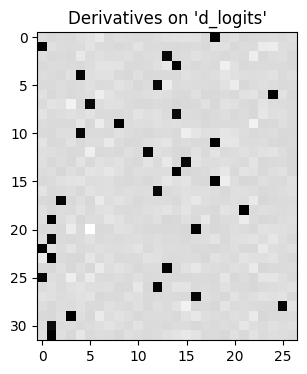

In [47]:
plt.figure(figsize=(4, 4))
plt.imshow(d_logits.detach(), cmap='gray')
plt.title("Derivatives on 'd_logits'")
# pulling down on probability on incorrect characters
# pushing up on the probability on correct characters
# the amount of pushes / pulls are equal because d_logits[0].sum() == 0
# amount of force is proportional to the probabilities that come out of the forward pass
# for example, if the probabilties from forward pass are exactly correct, there will be no force on probabilties and d_logits will be all 0
# for example, if an incorrect prediction is very confident (high probability) the pulling force will be quite strong

In [48]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bn_gain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bn_bias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [49]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bn_gain*bn_var_inv/n * (n*d_hpreact - d_hpreact.sum(0) - n/(n-1)*bn_raw*(d_hpreact*bn_raw).sum(0))
cmp('hprebn', d_hprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [50]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

# BatchNorm parameters
bn_gain = torch.randn((1, n_hidden))*0.1 + 1.0
bn_bias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

    # kick off optimization
    for i in tqdm(range(max_steps)):

        # minibatch construct
        ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
        Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bn_mean = hprebn.mean(0, keepdim=True)
        bn_var = hprebn.var(0, keepdim=True, unbiased=True)
        bn_var_inv = (bn_var + 1e-5)**-0.5
        bn_raw = (hprebn - bn_mean) * bn_var_inv
        hpreact = bn_gain * bn_raw + bn_bias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        d_logits = F.softmax(logits, 1)
        d_logits[range(n), Yb] -= 1
        d_logits /= n

        # 2nd layer backprop
        d_h = d_logits @ W2.T
        d_W2 = h.T @ d_logits
        d_b2 = d_logits.sum(0)

        # tanh
        d_hpreact = (1.0 - h**2) * d_h

        # batchnorm backprop
        d_bn_gain = (bn_raw * d_hpreact).sum(0, keepdim=True)
        d_bn_bias = d_hpreact.sum(0, keepdim=True)
        d_hprebn = bn_gain*bn_var_inv/n * (n*d_hpreact - d_hpreact.sum(0) - n/(n-1)*bn_raw*(d_hpreact*bn_raw).sum(0))

        # 1st layer
        d_embcat = d_hprebn @ W1.T
        d_W1 = embcat.T @ d_hprebn
        d_b1 = d_hprebn.sum(0)

        # embedding
        d_emb = d_embcat.view(emb.shape)
        d_C = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                d_C[ix] += d_emb[k,j]
        grads = [d_C, d_W1, d_b1, d_W2, d_b2, d_bn_gain, d_bn_bias]
        # -----------------

        # update
        lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

        # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
        #     break


12297


  0%|          | 0/200000 [00:00<?, ?it/s]

      0/ 200000: 3.6285
  10000/ 200000: 2.4975
  20000/ 200000: 2.3714
  30000/ 200000: 2.0870
  40000/ 200000: 2.0489
  50000/ 200000: 2.5658
  60000/ 200000: 2.2276
  70000/ 200000: 2.1229
  80000/ 200000: 1.9869
  90000/ 200000: 2.0313
 100000/ 200000: 2.3849
 110000/ 200000: 2.1199
 120000/ 200000: 2.1527
 130000/ 200000: 2.4721
 140000/ 200000: 2.1660
 150000/ 200000: 2.3003
 160000/ 200000: 2.0918
 170000/ 200000: 1.9652
 180000/ 200000: 2.3581
 190000/ 200000: 1.9644


In [53]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    # measure the mean/std over the entire training set
    bn_mean = hpreact.mean(0, keepdim=True)
    bn_var = hpreact.var(0, keepdim=True, unbiased=True)

In [54]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bn_gain * (hpreact - bn_mean) * (bn_var + 1e-5)**-0.5 + bn_bias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.072080135345459
val 2.1135950088500977


In [55]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])] # (1,block_size,d)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bn_gain * (hpreact - bn_mean) * (bn_var + 1e-5)**-0.5 + bn_bias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mritaymyah.
see.
med.
ryla.
reish.
jendraeg.
adee.
daeliah.
milopaleigh.
van.
narielleigh.
kalin.
shubergihi.
jest.
jair.
jennex.
terif.
ubelled.
ryyah.
faeh.


# Notes


- any time there is a sum, $\sum$, in the forward pass, that turns into a broadcasting in the backward pass along the same dimension.
- any time there is a broadcasting in the forward pass, that turns into a sum, $\sum$, in the backward pass along the same dimension.
- units must match - shape of `h` and `dh` must match
- backwards pass of a matrix multiplication is a matrix multiplication of the derivative and the _other_ term in the multiplication

$$
\begin{align}
d &= h @ W_2 + b_2 \\
\frac{dL}{dh} &= \frac{dL}{dd} @ W_2^\top \\
\frac{dL}{dW_2} &= h^\top @ \frac{dL}{dd} \\
\frac{dL}{db_2} &= \frac{dL}{dd} \cdot sum(0)
\end{align}
$$